# Predicting Health Insurance Costs

## Introduction

In this project, we are assigned data about health insurance contractors, and we aim to construct a model that could predict a given contractor's insurance charges.

## Exploratory Analysis

To start, we will perform an exploratory analysis on the data. This will help us understand the data, and decide what needs to be done to the data to preprocess it, and what techniques are necessary to build the best model. First, lets' take a look at the data.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_raw = pd.read_csv("insurance.csv")

display(data_raw.head(n=7))

e:\python27\lib\site-packages\pandas\_libs\__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected zd, got zd
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
e:\python27\lib\site-packages\pandas\__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected zd, got zd
  from pandas._libs import (hashtable as _hashtable,
e:\python27\lib\site-packages\pandas\core\dtypes\common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected zd, got zd
  from pandas._libs import algos, lib
e:\python27\lib\site-packages\pandas\core\util\hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected zd, got zd
  from pandas._libs import hashing, tslib
e:\python27\lib\site-packages\pandas\core\indexes\base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected zd, got zd
  f

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960


#### The data consists of 7 columns/variables:

- **Age:** The age of the contractor in years expressed as a numerical value.
- **Sex:** The contractor's sex, taking string values as either "male" or "female".
- **BMI:** The contactor's Body Mass Index, which represents the ratio of the body's mass to its height, expressed in numerical values.
- **Children:** Number of dependents of contractors, expressed as a numerical value.
- **Smoker:** Denotes whether the contractor smokes tobacco or not. Expressed in string values of "yes" and "no".
- **Region:** The region within the US where the contractor is. It is expressed in string values of "northeast", "northwest", "southeast", and "southwest".
- **Charges:** The monetary amount that was billed by the health insurance company, expressed in a numerical value.

To make the data more manageable, we will change all binary string values (**sex** and **smoker** features) to binary numerical values (0 and 1). **Regions** is a non-binary categorical feature. We can perform one-hot encoding on it, but we wil first analyze the data to determine if this is necessary.

In [2]:
data = data_raw.replace(['yes','no'], [1,0])
data = data.replace(['female','male'], [1,0])
display(data.head())

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,southwest,16884.92400
1,18,0,33.770,1,0,southeast,1725.55230
2,28,0,33.000,3,0,southeast,4449.46200
3,33,0,22.705,0,0,northwest,21984.47061
4,32,0,28.880,0,0,northwest,3866.85520


After the changes, we will create graphical representations of the data to better understand it.

Text(0.5,1,'Dependent Distribution')

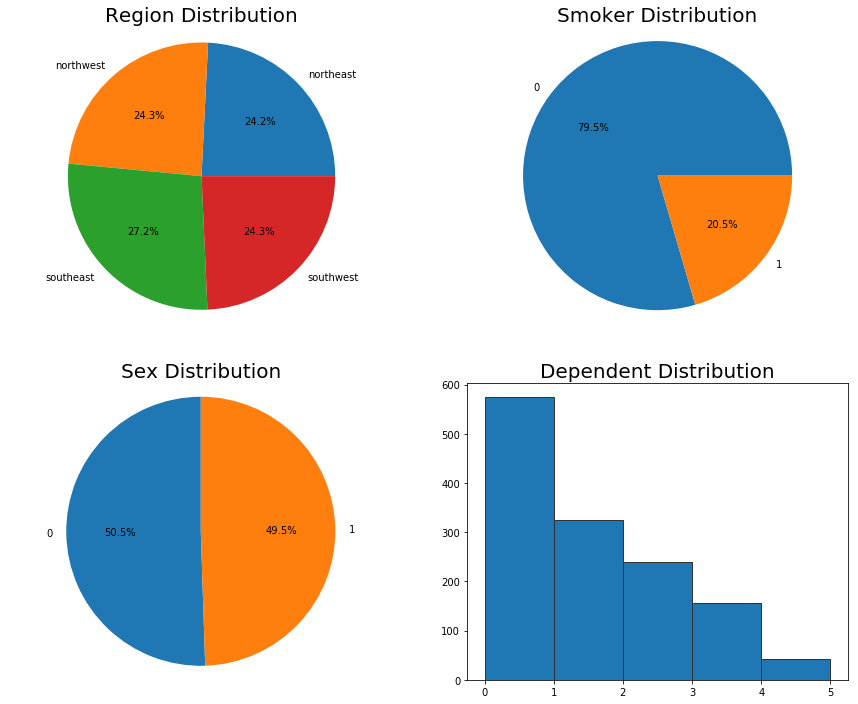

In [3]:
fig1, ((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2)
fig1.set_size_inches(15,12)
regionsizes = data.groupby("region").size().values
regionlabels = data.groupby('region').size().keys()

sexsizes = data.groupby("sex").size().values
sexlabels = data.groupby('sex').size().keys()

smokesizes = data.groupby("smoker").size().values
smokelabels = data.groupby('smoker').size().keys()

ax11.pie(regionsizes, labels=regionlabels, autopct='%1.1f%%')
ax11.set_title("Region Distribution", fontsize=20)
ax11.axis('equal')

ax13.pie(sexsizes, labels=sexlabels, autopct='%1.1f%%', startangle=90)
ax13.set_title("Sex Distribution", fontsize=20)
ax13.axis('equal')

ax12.pie(smokesizes, labels=smokelabels, autopct="%1.1f%%")
ax12.set_title("Smoker Distribution", fontsize=20)
ax12.axis('equal')

ax14.hist('children', data=data,edgecolor =' 0.2', bins = 5)
ax14.set_title("Dependent Distribution", fontsize=20)

> The contractors are divided between the 4 regions nearly equally, and are also split between the two sexes equally, as shown in the two pie charts on the left. The majority of contractors are non-smokers, and it is evident that contractors without children dominate, while the frequency decreases as the number of children goes up.

Text(0.5,1,'Charges Distribution')

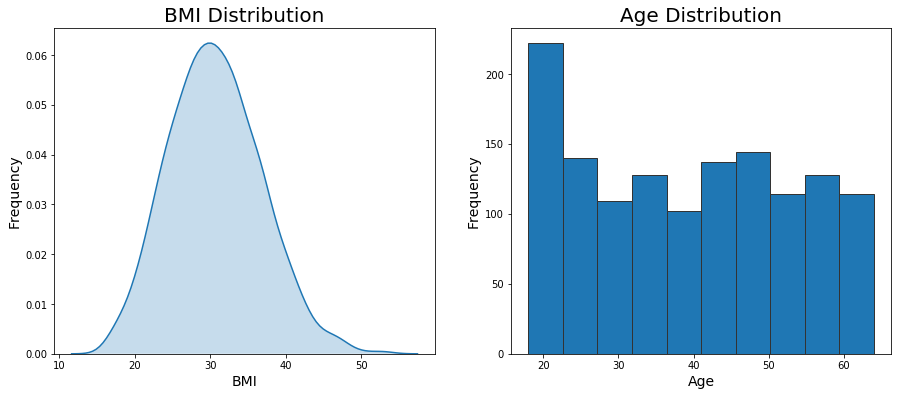

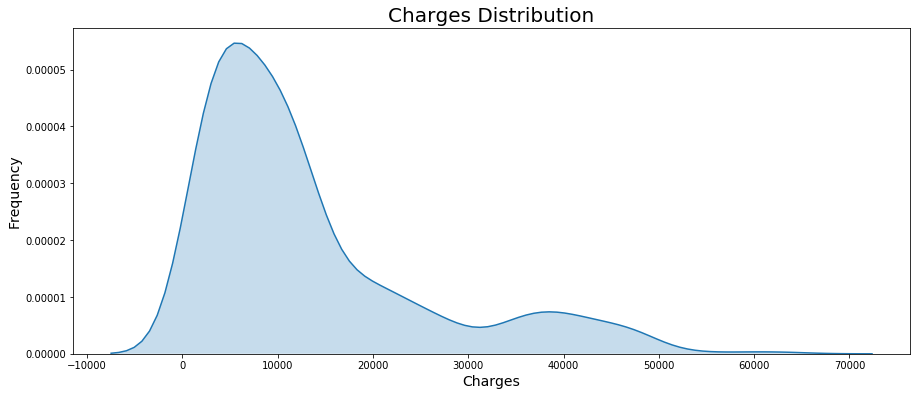

In [4]:
fig21, (ax21,ax22) = plt.subplots(1,2)
fig21.set_size_inches(15,6)

sns.kdeplot(data['bmi'], ax=ax21, shade=True, legend=False)
ax21.set_xlabel("BMI", fontsize=14)
ax21.set_ylabel("Frequency", fontsize=14)
ax21.set_title("BMI Distribution", fontsize=20)

ax22.hist('age', data=data, bins=10, edgecolor='0.2')
ax22.set_xlabel("Age", fontsize=14)
ax22.set_ylabel("Frequency", fontsize=14)
ax22.set_title("Age Distribution", fontsize=20)

fig22, ax23 = plt.subplots()
fig22.set_size_inches(15,6)
sns.kdeplot(data['charges'], ax=ax23, shade=True, legend=False)
ax23.set_xlabel("Charges", fontsize=14)
ax23.set_ylabel("Frequency", fontsize=14)
ax23.set_title("Charges Distribution", fontsize=20)

> - The BMI distribution is bell-shaped and symmetrical
- The Age distribution is mostly uniform, except for ages below 25 where the histogram peaks.
- The charges distribution is skewed to the left.

Left skewness is typical of monetary distributions. A logarithmic transformation is often useful for such distributions, and particularly monetary distributions, given that money values tend to be thought of as multiplicative more=so than additive. For example, a $100 difference between $50,100 and $50,000 might seem insignificant, whereas the same difference between $150 and $250 is not.

The feature of interest is the **charges** feature. Let's examine the effect of categorical features on the distribution of billed charges. The categorical features are: Region, Sex, abd Smoker. We will also treat the "children" feature as categorical and examine it in the same manner, because it only has 6 values.

Text(0.5,1,'Effect of Smoking on Cost')

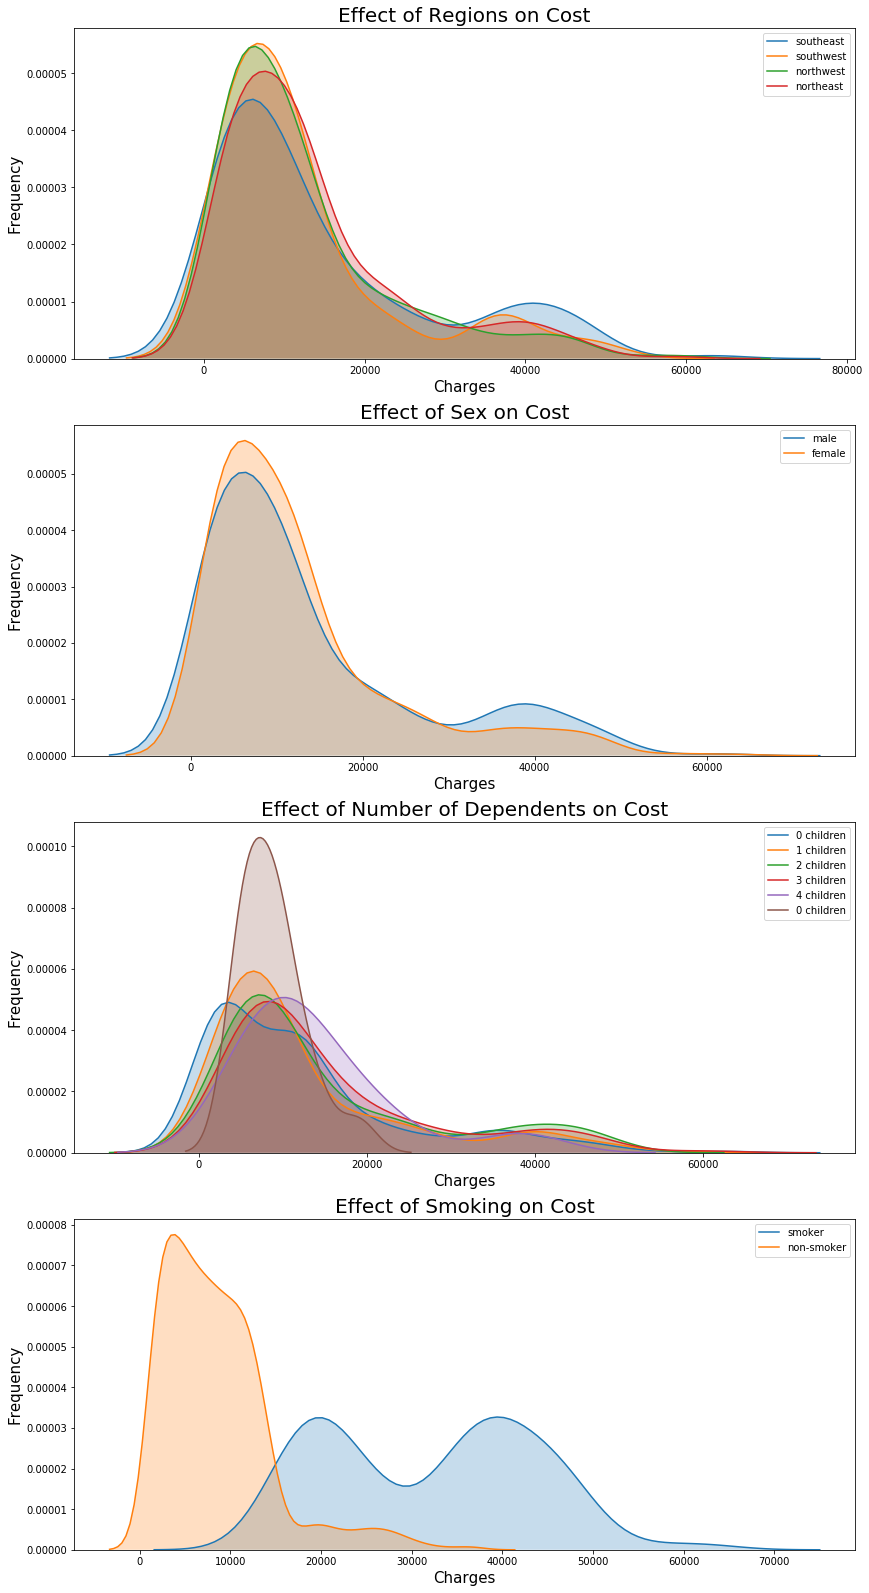

In [5]:
fig3, (ax31,ax32,ax33,ax34) = plt.subplots(4,1)
fig3.set_size_inches(14,28)

sns.kdeplot(data.loc[data["region"] == 'southeast']["charges"], ax=ax31, shade=True, label="southeast")
sns.kdeplot(data.loc[data["region"] == 'southwest']["charges"], ax=ax31, shade=True, label="southwest")
sns.kdeplot(data.loc[data["region"] == 'northwest']["charges"], ax=ax31, shade=True, label="northwest")
sns.kdeplot(data.loc[data["region"] == 'northeast']["charges"], ax=ax31, shade=True, label="northeast")
ax31.set_ylabel("Frequency", fontsize=15)
ax31.set_xlabel('Charges', fontsize=15)
ax31.set_title("Effect of Regions on Cost", fontsize=20)

sns.kdeplot(data.loc[data["sex"] == 0]["charges"], ax=ax32, shade=True, label="male")
sns.kdeplot(data.loc[data["sex"] == 1]["charges"], ax=ax32, shade=True, label="female")
ax32.set_ylabel("Frequency", fontsize=15)
ax32.set_xlabel('Charges', fontsize=15)
ax32.set_title("Effect of Sex on Cost", fontsize=20)

sns.kdeplot(data.loc[data["children"] == 0]["charges"], ax=ax33, shade=True, label="0 children")
sns.kdeplot(data.loc[data["children"] == 1]["charges"], ax=ax33, shade=True, label="1 children")
sns.kdeplot(data.loc[data["children"] == 2]["charges"], ax=ax33, shade=True, label="2 children")
sns.kdeplot(data.loc[data["children"] == 3]["charges"], ax=ax33, shade=True, label="3 children")
sns.kdeplot(data.loc[data["children"] == 4]["charges"], ax=ax33, shade=True, label="4 children")
sns.kdeplot(data.loc[data["children"] == 5]["charges"], ax=ax33, shade=True, label="0 children")
ax33.set_ylabel("Frequency", fontsize=15)
ax33.set_xlabel('Charges', fontsize=15)
ax33.set_title("Effect of Number of Dependents on Cost", fontsize=20)

sns.kdeplot(data.loc[data["smoker"] == 1]["charges"], ax=ax34, shade=True, label='smoker')
sns.kdeplot(data.loc[data["smoker"] == 0]["charges"], ax=ax34, shade=True, label='non-smoker')
ax34.set_ylabel("Frequency", fontsize=15)
ax34.set_xlabel('Charges', fontsize=15)
ax34.set_title("Effect of Smoking on Cost", fontsize=20)

> - The difference in region introduces no change to the cost distribution
- Sex also has no effect on cost
- All values of **children** do not effect the cost distribution, except for children = 5. But it is a small difference.
- **Smoking** makes a significant difference in cost, and hence is an important feature

> In Conclusion, region, sex, and children do not effect cost significantly, whereas smoking influences it very significantly.
Next, we will analyze continuous features' effects on cost using scatter plots.

e:\python27\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Charges')

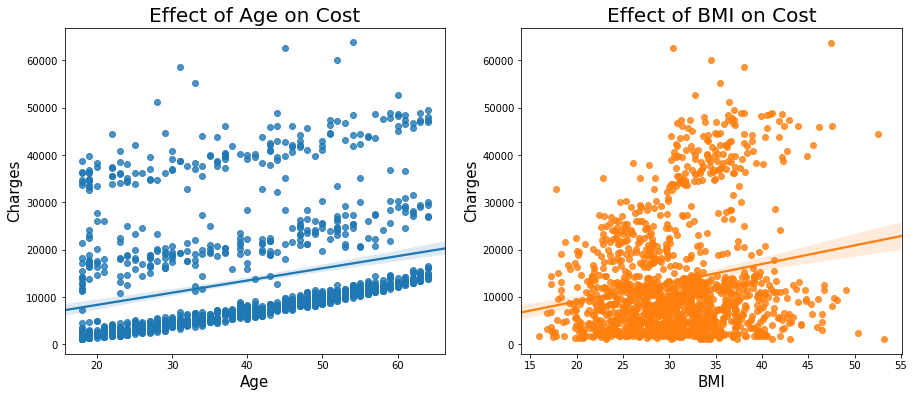

In [6]:
fig4, (ax41,ax42) = plt.subplots(1,2)
fig4.set_size_inches(15,6)
sns.regplot("age", "charges", data, ax=ax41)
ax41.set_title("Effect of Age on Cost", fontsize=20)
ax41.set_xlabel("Age", fontsize=15)
ax41.set_ylabel("Charges", fontsize=15)
sns.regplot("bmi", "charges", data, ax=ax42)
ax42.set_title("Effect of BMI on Cost", fontsize=20)
ax42.set_xlabel("BMI", fontsize=15)
ax42.set_ylabel("Charges", fontsize=15)

> Looking at the **Age** scatter plot, we can see that there are three distinct clusters. Most of the data resides in the bottom cluster, which more packed (smaller thickness) than the other two clusters. Each of the clusters exhibit a linear form, however, a simple least-squares regression between **Age** and **Charges** would not be good, because, as we can see, the best line fit has much error associated with it. a More Complicated model would be needed.
We can attempt to break up the data by the important feature, **Smoking**, and see if this would yield any of the clusters we see.

> **BMI** correlates with charges, but we could also attempt to break it up by by smoking to see if we get any clearer correlation.

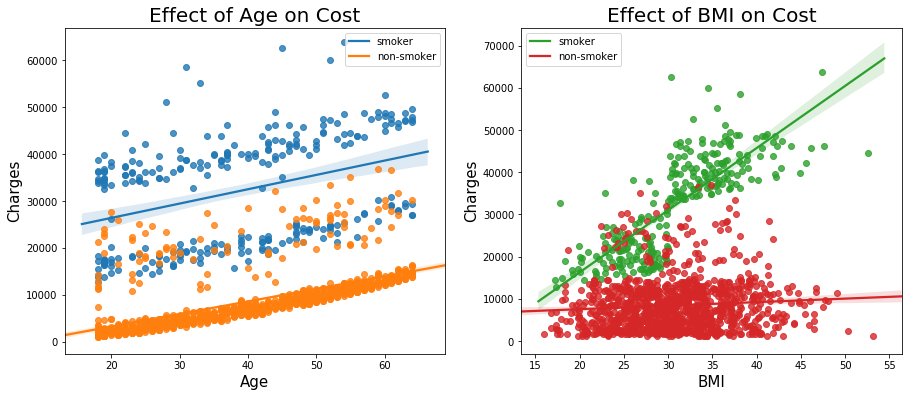

In [7]:
fig5, (ax51,ax52) = plt.subplots(1,2)
fig5.set_size_inches(15,6)
sns.regplot("age", "charges", data.loc[data["smoker"] == 1], ax=ax51)
sns.regplot("age", "charges", data.loc[data["smoker"] == 0], ax=ax51)
ax51.set_title("Effect of Age on Cost", fontsize=20)
ax51.set_xlabel("Age", fontsize=15)
ax51.set_ylabel("Charges", fontsize=15)
ax51.legend(("smoker", "non-smoker"))

sns.regplot("bmi", "charges", data.loc[data["smoker"] == 1], ax=ax52)
sns.regplot("bmi", "charges", data.loc[data["smoker"] == 0], ax=ax52)
ax52.set_title("Effect of BMI on Cost", fontsize=20)
ax52.set_xlabel("BMI", fontsize=15)
ax52.set_ylabel("Charges", fontsize=15)
ax52.legend(("smoker", "non-smoker"))

> When separating Age vs. Charges scatter plot by **smoking**, we see that all smoker contractors fell into the upper two clusters that were previously observed. The non-smoking section of the data included all of the bottom cluster, plus some of the middle cluster.

> In the BMI scatter plot, we can observe that for non-smokers, BMI has nearly no effect on cost. For smokers, however, there a strong trend. This means that it was the smoker data that was driving the correlation we witnessed above between all contractors' BMI and insurance charges.

Based on these observations, a regression tree would be the ideal model for this problem.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import r2_score

X = data.drop(['charges','sex','region'], axis=1)
Y = data["charges"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
#clf = DecisionTreeRegressor(max_depth=10,min_samples_split=3,max_leaf_nodes=10)
regress=DecisionTreeRegressor()
params_tree = {"max_depth":range(3,6), "min_samples_split":range(2,8), "max_leaf_nodes":range(2,20)}
grid_tree=GridSearchCV(regress, params)
grid_tree.fit(X_train,Y_train)
grid_tree.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=14, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [109]:
clf_tree = DecisionTreeRegressor(max_depth=3,min_impurity_decrease=0,min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0,max_leaf_nodes=16,presort=False,splitter="best", random_state=1)
clf_tree.fit(X_train,Y_train)
predictions_tree = clf.predict(X_test)
print(r2_score(predictions_tree, Y_test))

0.8063091708475556


          Gini-importance
smoker           0.707829
bmi              0.169397
age              0.120813
children         0.001961


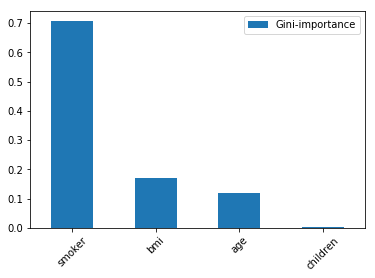

In [22]:

feats = {}
for feature, importance in zip(X_train.columns, clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance',ascending=False).plot(kind='bar', rot=45)
print(importances.sort_values(by='Gini-importance',ascending=False))
plt.show()

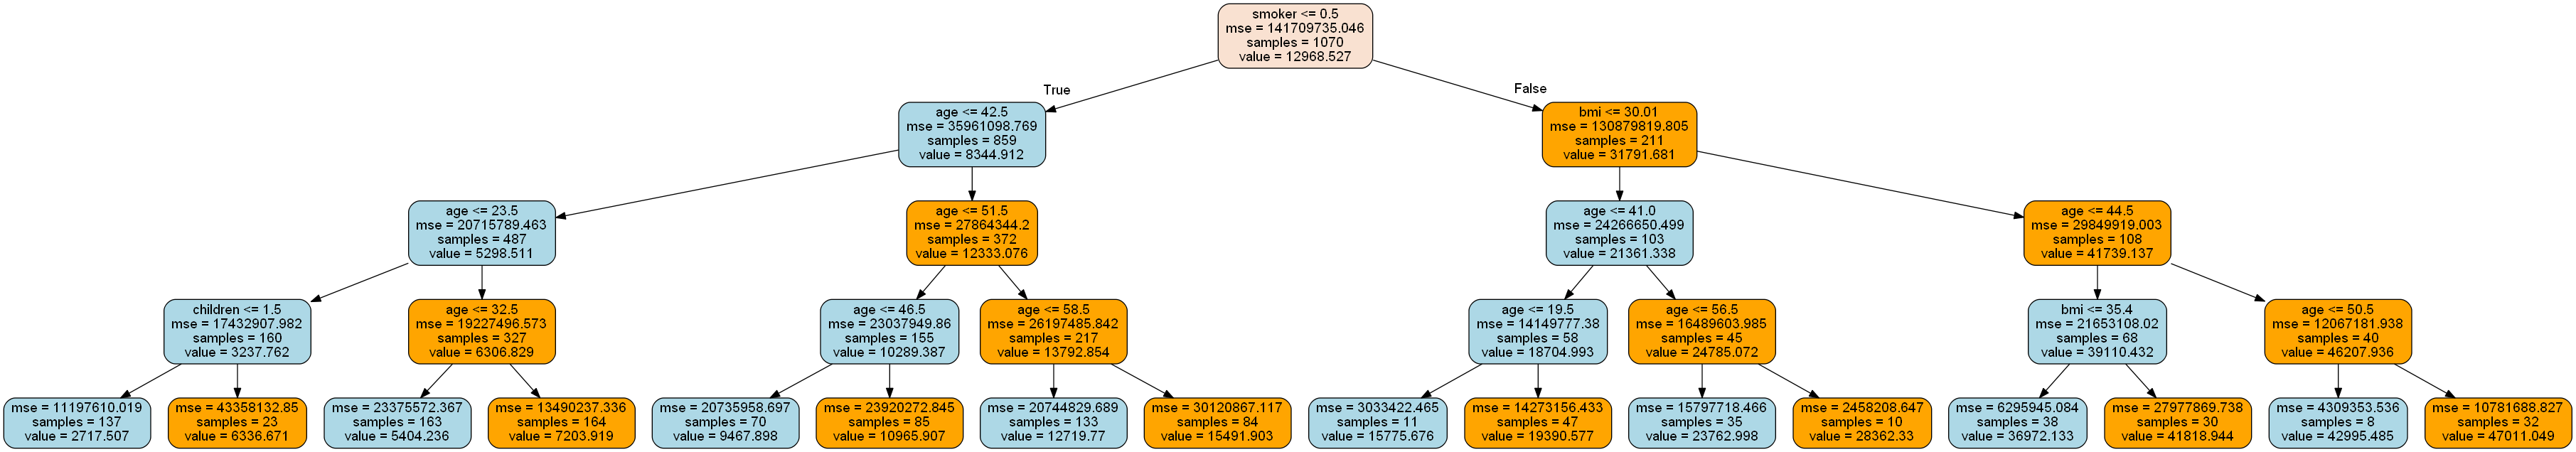

In [23]:
import pydotplus
from sklearn import tree
import collections
from PIL import Image

dot_data = tree.export_graphviz(clf, feature_names=X_train.columns, out_file=None,filled=True, rounded=True)


graph = pydotplus.graph_from_dot_data(dot_data)
colors = ( 'lightblue','orange')
edges = collections.defaultdict(list)
for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        
        dest.set_fillcolor(colors[i])
graph.write_png('tree.png')        

from IPython.display import Image
Image("tree.png")

In [24]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train,Y_train)
predictions_linear = linreg.predict(X_test)
r2_score(predictions_linear, Y_test)

0.6314002103829535

In [108]:
from sklearn.ensemble import AdaBoostRegressor

adaboost = AdaBoostRegressor(n_estimators=5, learning_rate=2)
#params_boost = {"n_estimators":range(20:200), ""}
#grid_boost = GridSearchCV()
adaboost.fit(X_train, Y_train)
predictions_boost = adaboost.predict(X_test)
r2_score(predictions_boost, Y_test)

0.7912084820734687